$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 5: Neural Networks

Luke Burford

## Overview

You will write and apply code that trains neural networks of various numbers of hidden layers and units in each hidden layer and returns results as specified below.  You will do this once for a regression problem and once for a classification problem. 

## Required Code

Download [nn2.tar](http://www.cs.colostate.edu/~anderson/cs440/notebooks/nn2.tar) that was used in lecture and extract its contents, which are

* `neuralnetworks.py`
* `scaledconjugategradient.py`
* `mlutils.py`

Write the following functions that train and evaluate neural network models.

* `results = trainNNs(X, T, trainFraction, hiddenLayerStructures, numberRepetitions, numberIterations, classify)`

The arguments to `trainNNs` are

* `X` is a matrix of input data of shape `nSamples x nFeatures`
* `T` is a matrix of target data of shape `nSamples x nOutputs`
* `trainFraction` is fraction of samples to use as training data. 1-`trainFraction` is number of samples for testing data
* `hiddenLayerStructures` is list of network architectures. For example, to test two networks, one with one hidden layer of 20 units, and one with 3 hidden layers with 5, 10, and 20 units in each layer, this argument would be `[[20], [5, 10, 20]]`.
* `numberRepetitions` is number of times to train a neural network.  Calculate training and testing average performance (two separate averages) of this many training runs.
* `numberIterations` is the number of iterations to run the scaled conjugate gradient algorithm when a neural network is trained.
* `classify` is set to `True` if you are doing a classification problem, in which case `T` must be a single column of target class integers.

This function returns `results` which is list with one element for each network structure tested.  Each element is a list containing 

* the hidden layer structure (as a list),
* a list of training data performance for each repetition, 
* a list of testing data performance for each repetition, and
* the number of seconds it took to run this many repetitions for this network structure.

This function should follow these steps:

  * For each network structure given in `hiddenLayerStructures`
    * For numberRepetitions
      * Use `ml.partition` to randomly partition X and T into training and testing sets.
      * Create a neural network of the given structure
      * Train it for numberIterations
      * Use the trained network to produce outputs for the training and for the testing sets
      * If classifying, calculate the fraction of samples incorrectly classified for training and testing sets.
       Otherwise, calculate the RMSE of training and testing sets.
      * Add the training and testing performance to a collection (such as a list) for this network structure
    * Add to a collection of all results the hidden layer structure, lists of training performance and testing performance, and seconds taken to do these repetitions.
  * return the collection of all results

Also write the following two functions. `summarize(results)` returns a list of lists like `results` but with the list of training performances replaced by their mean and the list of testing performances replaced by their mean.   
`bestNetwork(summary)` takes the output of `summarize(results)` and returns the best element of `results`, determined by the element that has the smallest test performance.

* `summary = summarize(results)` where `results` is returned by `trainNNs` and `summary` is like `results` with the training and testing performance lists replaced by their means
* `best = bestNetwork(summary)` where `summary` is returned by `summarize` and `best` is the best element of `summary`

In [490]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import neuralnetworks as nn
import mlutils as ml
import time
import sys

In [576]:
#note: calculates percentage of incorrect classifications, NOT correct classifications. I believe this is correct - double check results!
def checkAcc(A, B):
    checkC = 0
    numLen = len(B)
    for i in range(numLen):
        if A[i] != B[i]:
            checkC += 1
    return (checkC/numLen) 

**trainNNs(X, T, trainFraction, hiddenLayerStructures, numberRepetitions, numberIterations, classify=False):**

This is the backbone to the entire project, it follows more or less, what is described in the assignment page.

In [492]:
def trainNNs(X, T, trainFraction, hiddenLayerStructures, numberRepetitions, numberIterations, classify=False):
    
    results = [] #results will be in the format: [hiddenLayer, trainPerf, testPerf, time], and each hiddenLayer will contain this
    
    for hiddenLayer in hiddenLayerStructures:
        trainPerf = []  #training errors
        testPerf = []  #testing errors
        times = []  #training times
        start = time.time()
        for i in range(numberRepetitions):
            
            #Xtrain is training data, results of which are contrasted to Ttrain
            #Xtest is testing data, results of which are contrasted against Ttest
            Xtrain, Ttrain, Xtest, Ttest = ml.partition(X, T, (trainFraction, (1-trainFraction)), classification=classify)

            #next check for classification vs. non-classification:
            if classify:
                nnet = nn.NeuralNetworkClassifier(X.shape[1], hiddenLayer, len(np.unique(T)))
                nnet.train(Xtrain, Ttrain, numberIterations)
                #now net is created / trained, need to check accuracy of predictions now (Ctrain/Ctest)
                Ctrain = nnet.use(Xtrain)
                Ctest = nnet.use(Xtest)
                trainAcc = checkAcc(Ctrain, Ttrain)
                testAcc = checkAcc(Ctest, Ttest)
            
            
            #else:
            #shouldn't affect runtimes hardly at all (nanoseconds)
            else:
                nIn = Xtrain.shape[1]
                nOut = Ttrain.shape[1]
                nnet = nn.NeuralNetwork(nIn, hiddenLayer, nOut)
                nnet.train(Xtrain, Ttrain, nIterations = numberIterations)
                #now need to check accuracy of predictions
                Ctrain = nnet.use(Xtrain)
                Ctest = nnet.use(Xtest)
                #using root mean square error, check accuracy of nnet predictions:
                trainAcc = np.sqrt(np.mean((Ctrain-Ttrain)**2))
                testAcc = np.sqrt(np.mean((Ctest-Ttest)**2))
        
            trainPerf.append(trainAcc)
            testPerf.append(testAcc)
        
        endTime = time.time()
        results.append([hiddenLayer, trainPerf, testPerf, endTime-start])
    return results

**summarize(results):**

Summarize will replace individual errors by the mean of all errors.

In [493]:
def summarize(results):
    summary = []
    #[hiddenLayer, trainPerformance, testPerformance, time]
    for result in results:
        meanTrain = np.mean(np.array(result[1]))
        meanTest = np.mean(np.array(result[2]))
        summary.append([result[0], meanTrain, meanTest, result[3]])
    return summary  

**bestNetwork(summary):**

bestNetwork will take the output from `summarize(results)` and returns the best network (i.e. the network with the minimum error for a specific hidden layer)

In [494]:
def bestNetwork(summary):
    minT = float("inf")
    bestN = []
    for net in summary:
        if net[2] < minT:
            minT = net[2]
            bestN = net
    return bestN

## Examples


In [495]:
X = np.arange(10).reshape((-1,1))
T = X + 1 + np.random.uniform(-1, 1, ((10,1)))

In [496]:
import matplotlib.pyplot as plt
%matplotlib inline

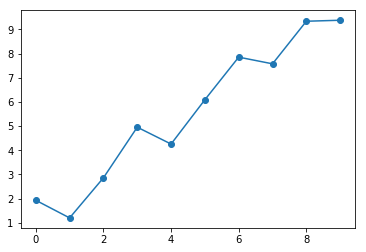

In [497]:
plt.plot(X, T, 'o-');

In [498]:
nnet = nn.NeuralNetwork(X.shape[1], 2, T.shape[1])
nnet.train(X, T, 100)
nnet.getErrorTrace()

array([0.71, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55,
       0.55, 0.28, 0.21, 0.19, 0.18, 0.16, 0.16, 0.16, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15])

In [499]:
nnet = nn.NeuralNetwork(X.shape[1], [5, 5, 5], T.shape[1])
nnet.train(X, T, 100)
nnet.getErrorTrace()

array([0.71, 0.66, 0.66, 0.64, 0.64, 0.43, 0.38, 0.19, 0.17, 0.17, 0.17,
       0.16, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15])

In [500]:
results = trainNNs(X, T, 0.8, [2, 10, [10, 10]], 5, 100, classify=False)
results

[[2,
  [0.5292481785252809,
   0.4040879068753891,
   0.36806410425830244,
   0.5644050844647379,
   0.5115924938436262],
  [0.34397543829137245,
   1.1217715547041962,
   1.7834370294907875,
   1.723909765473519,
   2.490461068760522],
  0.0939183235168457],
 [10,
  [0.0026891997557035264,
   0.4101016240466607,
   0.30232007227578983,
   0.28134921572326504,
   0.4386016618513572],
  [2.468903067356205,
   1.2229058137293325,
   1.2367133656691753,
   1.1965598263720891,
   1.0735068124317182],
  0.08854556083679199],
 [[10, 10],
  [0.09764903337234264,
   0.003091482671880658,
   0.020938493336343074,
   0.21029375698276667,
   0.5405558322566728],
  [1.2451606571915754,
   3.019814922288592,
   1.2017194458051916,
   0.9054286613899875,
   0.4154270515607918],
  0.13233065605163574]]

In [501]:
results = trainNNs(X, T, 0.8, [0, 1, 2, 10, [10, 10], [5, 5, 5, 5], [2]*5], 50, 100, classify=False)

In [502]:
summarize(results)

[[0, 0.6293300448800333, 0.8117285671400203, 0.02586674690246582],
 [1, 0.5458764933697341, 1.0159095259184303, 0.5560963153839111],
 [2, 0.49674418047676383, 1.2375923963894047, 0.8282885551452637],
 [10, 0.2744536209049067, 1.2528190762072244, 0.9102084636688232],
 [[10, 10], 0.3516263203332404, 1.2104493680660406, 1.2615094184875488],
 [[5, 5, 5, 5], 0.4657656973185385, 1.3119587734729268, 1.7200722694396973],
 [[2, 2, 2, 2, 2], 0.5527269398747616, 1.0588326061543987, 1.8843481540679932]]

In [503]:
best = bestNetwork(summarize(results))
print(best)
print('Hidden Layers {} Average RMSE Training {:.2f} Testing {:.2f} Took {:.2f} seconds'.format(*best))

[0, 0.6293300448800333, 0.8117285671400203, 0.02586674690246582]
Hidden Layers 0 Average RMSE Training 0.63 Testing 0.81 Took 0.03 seconds


Hummm...neural nets with no hidden layers did best on this simple data set.  Why?  Remember what "best" means.

## Data for Regression Experiment

From the UCI Machine Learning Repository, download the [Appliances energy prediction](http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction) data.  You can do this by visiting the Data Folder for this data set, or just do this:

     !wget http://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv



Read this data into python.  One suggestion is to use the `loadtxt` function in the `numpy` package.  You may ignore the first column of each row which contains a data and time.  Also ignore the last two columns of random variables.  We will not use that in our modeling of this data.  You will also have to deal with the double quotes that surround every value in every field.  Read the first line of this file to get the names of the features.

Once you have read this in correctly, you should see values like this:

In [504]:
     #!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv

--2018-11-05 20:05:51--  http://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11979363 (11M) [text/csv]
Saving to: ‘energydata_complete.csv.3’

energydata_complete 100%[===================>]  11.42M  5.63MB/s    in 2.0s    

2018-11-05 20:05:53 (5.63 MB/s) - ‘energydata_complete.csv.3’ saved [11979363/11979363]



I decided to use pandas since it plots in a very nice way and seems easier to parse the file.

In [505]:
#parse the file using pandas and assign the appropiate values
data= pd.read_csv('energydata_complete.csv')
del data['date']
del data['rv1']
del data['rv2']
XenergyDF = data.iloc[:,2:]
TenergyDF = data.iloc[:,:2]
Xnames = list(XenergyDF)
Tnames = list(TenergyDF)

In [506]:
names

['date',
 'Appliances',
 'lights',
 'T1',
 'RH_1',
 'T2',
 'RH_2',
 'T3',
 'RH_3',
 'T4',
 'RH_4',
 'T5',
 'RH_5',
 'T6',
 'RH_6',
 'T7',
 'RH_7',
 'T8',
 'RH_8',
 'T9',
 'RH_9',
 'T_out',
 'Press_mm_hg',
 'RH_out',
 'Windspeed',
 'Visibility',
 'Tdewpoint',
 'rv1',
 'rv2']

In [507]:
data.shape

(19735, 26)

In [508]:
data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9


Use the first two columns, labelled `Appliances` and `lights` as the target variables, and the remaining 24 columns as the input features.  So

In [509]:
Xenergy = XenergyDF.values
Tenergy = TenergyDF.values

In [510]:
Xenergy.shape, Tenergy.shape

((19735, 24), (19735, 2))

In [511]:
Xnames

['T1',
 'RH_1',
 'T2',
 'RH_2',
 'T3',
 'RH_3',
 'T4',
 'RH_4',
 'T5',
 'RH_5',
 'T6',
 'RH_6',
 'T7',
 'RH_7',
 'T8',
 'RH_8',
 'T9',
 'RH_9',
 'T_out',
 'Press_mm_hg',
 'RH_out',
 'Windspeed',
 'Visibility',
 'Tdewpoint']

In [512]:
Tnames

['Appliances', 'lights']

Train several neural networks on all of this data for 100 iterations.  Plot the error trace (nnet.getErrorTrace()) to help you decide now many iterations might be needed.  100 may not be enough.  If for your larger networks the error is still decreasing after 100 iterations you should train all nets for more than 100 iterations.

Now use your `trainNNs`, `summarize`, and `bestNetwork` functions on this data to investigate various network sizes.

In [513]:
results = trainNNs(Xenergy, Tenergy, 0.8, [0, 5, [5, 5], [10, 10]], 10, 100)

In [514]:
summarize(results)

[[0, 67.33770436206602, 66.47139019027814, 0.7472779750823975],
 [5, 65.62243232557142, 65.82470079032218, 6.985296964645386],
 [[5, 5], 64.84400231983406, 65.2808025930875, 9.16442060470581],
 [[10, 10], 63.1601143031089, 63.60413906527879, 12.054701328277588]]

In [515]:
bestNetwork(summarize(results))

[[10, 10], 63.1601143031089, 63.60413906527879, 12.054701328277588]

**plotET(net):**

Plots the error trace of a net.

In [516]:
def plotET(net):
    err = nnet.getErrorTrace()
    plt.figure()
    plt.plot(range(len(err)), nnet.getErrorTrace());

When looking at a plot for the error trace. It drops drastically by the first 20 or so repetitions.

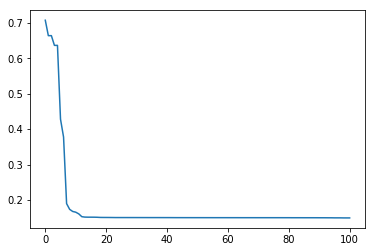

In [518]:
plotET(nnet)

Test at least 10 different hidden layer structures.  Larger numbers of layers and units may do the best on training data, but not on testing data. Why?

Now train another network with your best hidden layer structure on 0.8 of the data and use the trained network on the testing data (the remaining 0.2 of the date).  As before use `ml.partition` to produce the training and testing sets.

For the testing data, plot the predicted and actual `Appliances` energy use, and the predicted and actual `lights` energy use, in two separate plots.  Discuss what you see.

In [519]:
hiddenLayers = []

hiddenLayers.append(2)
hiddenLayers.append([4,4])
hiddenLayers.append([6,6])
hiddenLayers.append([8,8])
hiddenLayers.append([10,10])
hiddenLayers.append([7,14])
hiddenLayers.append([14,7])
hiddenLayers.append([13,13])
hiddenLayers.append([15,15])
hiddenLayers.append([18,18])

In [520]:
results = trainNNs(Xenergy, Tenergy, 0.8, hiddenLayers, 10, 100)

In [521]:
summarize(results)

[[2, 66.42874763411643, 66.17252667711065, 5.874348402023315],
 [[4, 4], 65.22726809039439, 65.47011711715466, 7.218940019607544],
 [[6, 6], 64.48326586370301, 65.06952207606216, 9.714118719100952],
 [[8, 8], 63.510327633933855, 66.19886392953245, 9.980035305023193],
 [[10, 10], 63.18660472715469, 64.05880947243055, 11.080468654632568],
 [[7, 14], 63.57616936915789, 64.44602898923996, 12.21626615524292],
 [[14, 7], 62.27267488400433, 64.6030775429617, 11.670969009399414],
 [[13, 13], 62.39010093309592, 64.8053936944643, 13.994156122207642],
 [[15, 15], 62.468233217256184, 64.23657046766132, 14.649054527282715],
 [[18, 18], 61.75500066926213, 63.417876351385374, 16.27055835723877]]

In [522]:
bestNetwork(summarize(results))

[[18, 18], 61.75500066926213, 63.417876351385374, 16.27055835723877]

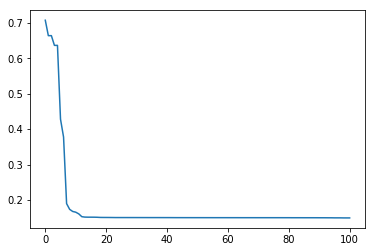

In [528]:
plotET(nnet)

It seems that a bigger hiddenLayer yields the best result, so lets test some bigger 
Now for some more intense tests:

In [523]:
hiddenLayersList = []
hiddenLayersList.append([20,20])
hiddenLayersList.append([29,29])
hiddenLayersList.append([38,38])
hiddenLayersList.append([60,60])

In [524]:
results = trainNNs(Xenergy, Tenergy, 0.8, hiddenLayersList, 10, 100)

In [525]:
summarize(results)

[[[20, 20], 61.48452405547424, 64.05712505887384, 17.683578491210938],
 [[29, 29], 61.84333462547859, 62.92191410427701, 26.884979248046875],
 [[38, 38], 61.5377869232081, 62.700320353390396, 31.28783655166626],
 [[60, 60], 61.89111943665988, 63.729589476179775, 57.692304849624634]]

In [526]:
bestNetwork(summarize(results))

[[38, 38], 61.5377869232081, 62.700320353390396, 31.28783655166626]

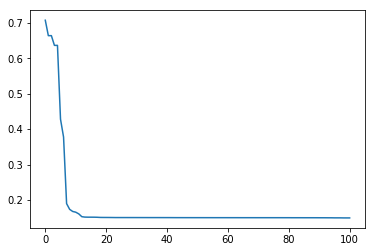

In [529]:
plotET(nnet)

It seems that bigger is better until a certain extent. This is most likely capped by overfitting. This seems to require a little trial and error for each different problem.

In [530]:
start = time.time()
Xtrain, Ttrain, Xtest, Ttest = ml.partition(Xenergy, Tenergy, (0.8, 0.2))
nnet = nn.NeuralNetwork(Xenergy.shape[1], [35,35], Tenergy.shape[1])
nnet.train(Xtrain, Ttrain, 100)
Ctrain = nnet.use(Xtrain)
Ctest = nnet.use(Xtest)
trainAcc = np.sqrt(np.mean((Ctrain-Ttrain)**2))
testAcc = np.sqrt(np.mean((Ctest-Ttest)**2))
endTime = time.time()

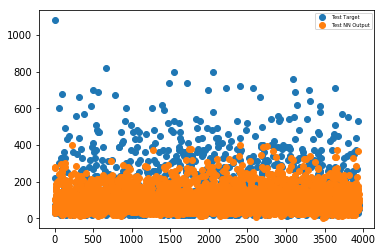

In [543]:
plt.subplot(1,1,1)
plt.plot(Ttest[:,:1], 'o', Ctest[:,:1],'o')
pltz.legend(('Test Target','Test NN Output'),loc='upper right',
            prop={'size':5});

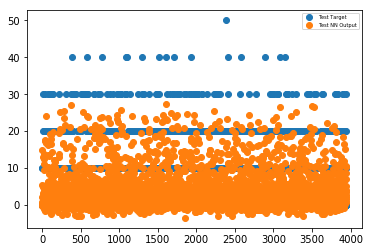

In [541]:
plt.subplot(1,1,1)
plt.plot(Ttest[:,1:], 'o', Ctest[:,1:],'o')
plt.legend(('Test Target','Test NN Output'),loc='upper right',
            prop={'size':5});

We seem to have a pretty good coverage of test targert. It has some strange outliers sometimes but I think that this is caused by the wide range of data that the network has to cover

## Data for Classification Experiment

From the UCI Machine Learning Repository, download the [Anuran Calls (MFCCs)](http://archive.ics.uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29) data.  You can do this by visiting the Data Folder for this data set, or just do this:

     !wget 'http://archive.ics.uci.edu/ml/machine-learning-databases/00406/Anuran Calls (MFCCs).zip'
     !unzip Anuran*zip
     
Read the data in the file `Frogs_MFCCs.csv` into python.  This will be a little tricky. Each line of the file is a sample of audio features plus three columns that label the sample by family, genus, and species. We will try to predict the species.  The tricky part is that the species is given as text.  We need to convert this to a target class, as an integer. The `numpy` function `unique` will come in handy here.

I use the command !wget and !unzip as shown below:

In [550]:
 #!wget 'http://archive.ics.uci.edu/ml/machine-learning-databases/00406/Anuran Calls (MFCCs).zip'
 #!unzip Anuran*zip

--2018-11-05 20:40:49--  http://archive.ics.uci.edu/ml/machine-learning-databases/00406/Anuran%20Calls%20(MFCCs).zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1300058 (1.2M) [application/zip]
Saving to: ‘Anuran Calls (MFCCs).zip.1’

Anuran Calls (MFCCs 100%[===================>]   1.24M  1.72MB/s    in 0.7s    

2018-11-05 20:40:50 (1.72 MB/s) - ‘Anuran Calls (MFCCs).zip.1’ saved [1300058/1300058]

Archive:  Anuran Calls (MFCCs).zip
replace Frogs_MFCCs.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [605]:
data = pd.read_csv('Frogs_MFCCs.csv')
Xanuran = data.iloc[:,:22]
TanuranTemp = data['Species']

In [606]:
TanuranTemp.head()

0    AdenomeraAndre
1    AdenomeraAndre
2    AdenomeraAndre
3    AdenomeraAndre
4    AdenomeraAndre
Name: Species, dtype: object

In [607]:
classNames = np.unique(TanuranTemp)
classNameDict = {}
for i in range(len(classNames)):
    classNameDict[classNames[i]] = i
    
Tanuran = TanuranTemp.copy()
for i in range(len(TanuranTemp)):
    Tanuran.loc[i] = classNameDict[TanuranTemp.loc[i]]
Tanuran=Tanuran.values.reshape(7195,1)

In [608]:
Xanuran.shape, Tanuran.shape

((7195, 22), (7195, 1))

In [609]:
Xanuran.head()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.156436,0.082245,0.135752,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.254341,0.022786,0.163320,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.237384,0.050791,0.207338,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.317084,-0.011567,0.100413,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.298524,0.037439,0.219153,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244


In [610]:
for i in range(10):
    print('{} samples in class {}'.format(np.sum(Tanuran==i), i))

672 samples in class 0
3478 samples in class 1
542 samples in class 2
310 samples in class 3
472 samples in class 4
1121 samples in class 5
270 samples in class 6
114 samples in class 7
68 samples in class 8
148 samples in class 9


In [611]:
Xanuran = XanuranDF.values

Okay! so it looks like ive got it all parsed in (all be it not very pretty but it does seem to work! Now we can test it with the NN.

In [612]:
results = trainNNs(Xanuran, Tanuran, 0.8, [0, 5, [5, 5]], 5, 100, classify=True)

In [613]:
summarize(results)

[[0, 0.034016678248783884, 0.03766504517025712, 1.1870372295379639],
 [5, 0.03537178596247394, 0.046143154968728284, 2.072094202041626],
 [[5, 5], 0.04374565670604587, 0.057261987491313414, 2.4782326221466064]]

In [614]:
bestNetwork(summarize(results))

[0, 0.034016678248783884, 0.03766504517025712, 1.1870372295379639]

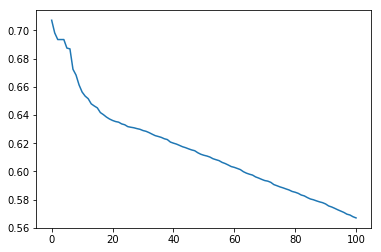

In [615]:
plotET(nnet)

Now do an investigation like you did for the regression data. 

Test at least 10 different hidden layer structures. Then train another network with your best hidden layer structure on 0.8 of the data and use the trained network on the testing data (the remaining 0.2 of the date). 

Plot the predicted and actual `Species` for the testing data as an integer.  Discuss what you see.

In [596]:
hiddenLayers = []

hiddenLayers.append(2)
hiddenLayers.append([4,4])
hiddenLayers.append([6,6])
hiddenLayers.append([8,8])
hiddenLayers.append([10,10])
hiddenLayers.append([7,14])
hiddenLayers.append([14,7])
hiddenLayers.append([13,13])
hiddenLayers.append([15,15])
hiddenLayers.append([60,60])

In [597]:
results = trainNNs(Xanuran, Tanuran, 0.8, hiddenLayers, 10, 100, classify=True)

In [598]:
summarize(results)

[[2, 0.15119874913134118, 0.15378735232800558, 3.8745057582855225],
 [[4, 4], 0.08038568450312718, 0.08624044475330091, 4.507368564605713],
 [[6, 6], 0.03492008339124392, 0.046629603891591376, 5.016716480255127],
 [[8, 8], 0.016817234190410008, 0.033148019457956916, 5.362592458724976],
 [[10, 10], 0.006184850590687977, 0.027102154273801256, 5.925294399261475],
 [[7, 14], 0.014732453092425296, 0.030785267546907573, 6.192589521408081],
 [[14, 7], 0.002970813064628214, 0.022446143154968727, 6.047893524169922],
 [[13, 13], 0.0011466296038915914, 0.021195274496177897, 6.743886709213257],
 [[15, 15], 0.0001389854065323141, 0.0207088255733148, 7.015833854675293],
 [[60, 60], 0.0, 0.01007644197359277, 16.058104515075684]]

In [599]:
bestNetwork(summarize(results))

[[60, 60], 0.0, 0.01007644197359277, 16.058104515075684]

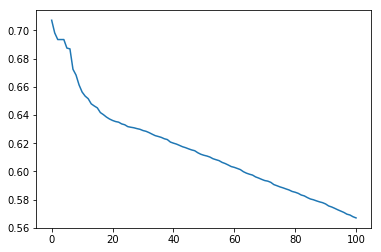

In [600]:
plotET(nnet)

In [591]:
hiddenLayersList = []
hiddenLayersList.append([20,20])
hiddenLayersList.append([29,29])
hiddenLayersList.append([38,38])
hiddenLayersList.append([60,60])

In [592]:
results = trainNNs(Xanuran, Tanuran, 0.8, hiddenLayers, 10, 100, classify=True)

In [593]:
summarize(results)

[[2, 0.1580611535788742, 0.15837387074357195, 3.889312505722046],
 [[4, 4], 0.07263724808895065, 0.07949965253648367, 4.5911290645599365],
 [[6, 6], 0.050990271021542743, 0.0626129256428075, 5.221827507019043],
 [[8, 8], 0.012873523280055593, 0.029256428075052115, 5.579189300537109],
 [[10, 10], 0.006567060458651843, 0.026546212647671995, 6.262535572052002],
 [[7, 14], 0.012439193884642112, 0.029812369701181375, 6.1918275356292725],
 [[14, 7], 0.00613273106323836, 0.02640722724113968, 6.106868505477905],
 [[13, 13], 0.0016504517025712298, 0.022446143154968727, 6.445233583450317],
 [[15, 15], 0.00026059763724808893, 0.020708825573314806, 7.043168544769287],
 [[18, 18], 0.0, 0.017025712300208475, 7.565645217895508]]

In [594]:
bestNetwork(summarize(results))

[[18, 18], 0.0, 0.017025712300208475, 7.565645217895508]

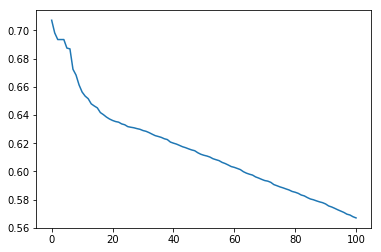

In [595]:
plotET(nnet)

Ive tried to work through a bunch of different types of hiddenLayers but I found it very difficult to yield a confident network.

In [616]:
%run -i "A5grader.py"


======================= Code Execution =======================

Extracting python code from notebook named 'Boston-A5.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing summarize([[[1,1], [1.2, 1.3, 1.4], [2.2, 2.3, 2.4], 0.5], [[2,2,2], [4.4, 4.3, 4.2], [6.5, 6.4, 6.3], 0.6]])

--- 10/10 points. Correctly returned [[[1, 1], 1.3, 2.3000000000000003, 0.5], [[2, 2, 2], 4.3, 6.3999999999999995, 0.6]]

Testing bestNetwork([[[1, 1], 1.3, 2.3, 0.5], [[2, 2, 2], 4.3, 1.3, 0.6]])

--- 10/10 points. Correctly returned [[2, 2, 2], 4.3, 1.3, 0.6]

X = np.random.uniform(-1, 1, (100, 3))
T = np.hstack(((X**2 - 0.2*X**3).sum(axis=1,keepdims=True),
               (np.sin(X)).sum(axis=1,keepdims=True)))
result = trainNNs(X, T, 0.7, [0, 5, 10, [20, 20]], 10, 100, False)

--- 20/20 points. Correct.

Testing bestNetwork(summarize(result))

--- 20/20 points. You correctly found that network [20, 20] is best.

A5 Execution Grade

<Figure size 432x288 with 0 Axes>

Grader Checks out!